# Build synthetic profiles

Use PyBaMM to initialize a DFN model to act as a surrogate model for a physical battery. 

Use this model to generate use cases.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybamm
import sys

sys.path.append('../')

from src import plotter as plotter
plotter.initialize(plt)

## Set up model and parameters

In [2]:
model            = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues("Chen2020")
solver           = pybamm.IDAKLUSolver(options={'dt_max':1})

# Set up global parameters

In [3]:
VOLTAGE_STD_LOW = 0.0002*5 #0.02% of FSR with 5V range = 1 mV; represents high precision lab equipment
VOLTAGE_STD_HIGH = 0.01;   # 10 mV of voltage noise; represents on-board equipment

## First simulate a 1C discharge to obtain some nominal value for cell energy

In [4]:
experiment      = pybamm.Experiment(
    ["Discharge at 1C until 2.5V"]
    )

sim = pybamm.Simulation(model=model,
                        parameter_values=parameter_values,
                        experiment=experiment,
                        solver=solver)

sol = sim.solve(initial_soc=1)

time = sol["Time [s]"].data
power = sol["Power [W]"].data
current = sol["Current [A]"].data
energy = np.cumsum(power * np.diff(np.append(0, time))) / 3600
capacity = np.cumsum(current * np.diff(np.append(0, time))) / 3600

nominal_energy = energy[-1]
nominal_capacity = capacity[-1]

print(f"Nominal energy: {nominal_energy:.2f} Wh")
print(f"Nominal capacity: {nominal_capacity:.2f} Ah")

Nominal energy: 17.50 Wh
Nominal capacity: 4.99 Ah


In [5]:
def summarize_solution(sol, voltage_std=0.01):
    """
    Extracts the time series data from a PyBaMM solution object and returns a DataFrame
    with the time series data.

    Adds noise to the voltage output.

    Args:
    sol (pybamm.Solution): PyBaMM solution object

    Returns:
    df_data (pd.DataFrame): DataFrame containing the time series data
    """

    time_vec = sol["Time [s]"].data
    current_vec = sol["Current [A]"].data
    power_vec = sol["Power [W]"].data
    voltage_vec = sol["Voltage [V]"].data

    voltage_vec = voltage_vec + \
        np.random.normal(0, voltage_std, size=len(voltage_vec))
    energy_vec = np.cumsum(power_vec * np.diff(np.append(0, time_vec))) / 3600
    capacity_vec = np.cumsum(current_vec * np.diff(np.append(0, time_vec))) / 3600

    # Create a DataFrame to store the time series data
    df_data = pd.DataFrame({
        'Time [s]': time_vec,
        'Current [A]': current_vec,
        'Power [W]': power_vec,
        'Voltage [V]': voltage_vec,
        'Capacity [Ah]': capacity_vec,
        'Energy [Wh]': energy_vec
    })

    return df_data

## Use Case 1: Energy Mode

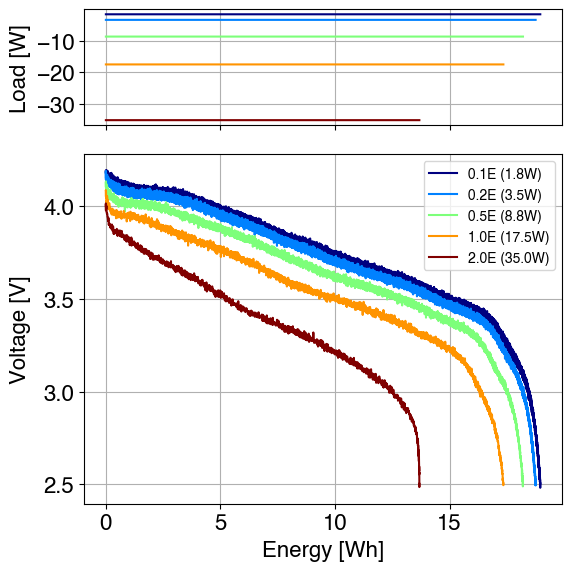

In [6]:
# Set the discharge powers to simulate
e_rate_list = np.array([0.1, 0.2, 0.5, 1.0, 2.0])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])
plt.subplots_adjust(hspace=0)

# Create a colormap with enough colors for our e_rates
colors = plt.cm.jet(np.linspace(0, 1, len(e_rate_list)))

for e_rate, color in zip(e_rate_list, colors):

    experiment = pybamm.Experiment(
        [f"Discharge at {e_rate*nominal_energy:.2f}W until 2.5V"]
        )

    sim = pybamm.Simulation(model=model,
                            parameter_values=parameter_values,
                            experiment=experiment,
                            solver=solver)

    sol = sim.solve(initial_soc=1)

    df = summarize_solution(sol, voltage_std=VOLTAGE_STD_HIGH)
    df.to_csv(f'../output/synthetic_data/use_case_1_{e_rate:.1f}E.csv')

    ax1.plot(df['Energy [Wh]'], -df['Power [W]'], color=color)
    ax2.plot(df['Energy [Wh]'], df['Voltage [V]'], color=color,
             label=f"{e_rate:.1f}E ({e_rate*nominal_energy:.1f}W)")

ax1.set_ylabel("Load [W]")
ax2.set_ylabel("Voltage [V]")
ax2.set_xlabel("Energy [Wh]")

plt.tight_layout()
fig.align_ylabels([ax1, ax2])
ax2.legend(fontsize=10)

plt.savefig('../output/figs/use_case_1.png', dpi=150)

# Use Case 2: Power Mode

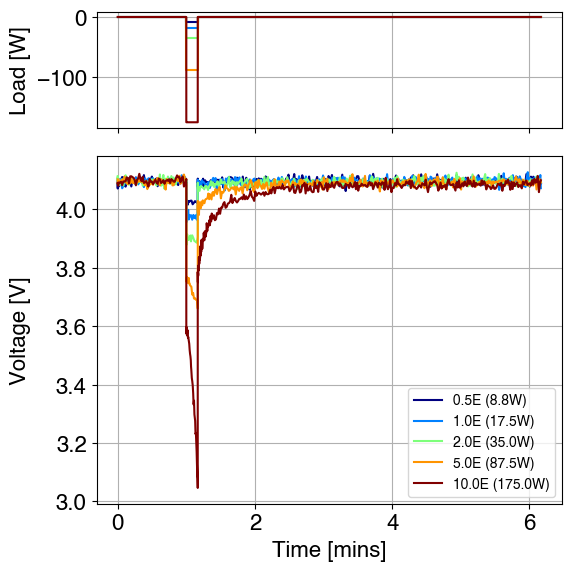

In [7]:
# Set the discharge powers to simulate
e_rate_list = np.array([0.5, 1.0, 2.0, 5.0, 10.0])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])
plt.subplots_adjust(hspace=0)

# Create a colormap with enough colors for our e_rates
colors = plt.cm.jet(np.linspace(0, 1, len(e_rate_list)))

for e_rate, color in zip(e_rate_list, colors):

    experiment = pybamm.Experiment(
        [
            "Rest for 1 minute",
            f"Discharge at {e_rate*nominal_energy:.2f} W for 10 seconds",
            "Rest for 5 minutes"
        ]
    )

    sim = pybamm.Simulation(model=model,
                            parameter_values=parameter_values,
                            experiment=experiment,
                            solver=solver)

    sol = sim.solve(initial_soc=0.9)

    df = summarize_solution(sol, voltage_std=VOLTAGE_STD_HIGH)

    df.to_csv(f'../output/synthetic_data/use_case_2_{e_rate:.1f}E.csv')

    ax1.plot(df['Time [s]']/60, -df['Power [W]'], color=color)
    ax2.plot(df['Time [s]']/60, df['Voltage [V]'], color=color,
             label=f"{e_rate:.1f}E ({e_rate*nominal_energy:.1f}W)")

ax1.set_ylabel("Load [W]")
ax2.set_ylabel("Voltage [V]")
ax2.set_xlabel("Time [mins]")
fig.align_ylabels([ax1, ax2])
ax2.legend(fontsize=10)
plt.tight_layout()

plt.savefig('../output/figs/use_case_2.png', dpi=150)

# Use Case 3: Dynamic Load Profile

2025-03-20 10:25:47.324 - [WARNING] callbacks.on_experiment_infeasible_time(240): 

	Experiment is infeasible: default duration (1851.9 seconds) was reached during 'Step([[0.0000e+00 1.9400e-01]
 [1.0000e-01 1.9400e-01]
 [2.0000e-01 1.9400e-01]
 ...
 [1.8517e+03 1.4000e-02]
 [1.8518e+03 1.4000e-02]
 [1.8519e+03 1.4000e-02]], duration=1851.9, period=0.09999999999990905, direction=Discharge)'. The returned solution only contains up to step 1 of cycle 1. Please specify a duration in the step instructions.


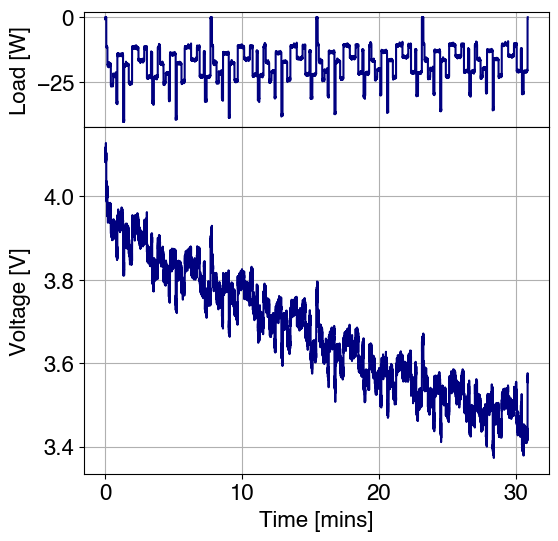

In [8]:
df = pd.read_csv("../data/load_profile_usc_dynamic.csv")

# Create copies with adjusted time
current_data1 = np.column_stack([df.time - df.time[0] + 0*df.time.iloc[-1], df.load])
current_data2 = np.column_stack([df.time - df.time[0] + 1*df.time.iloc[-1], df.load])
current_data3 = np.column_stack([df.time - df.time[0] + 2*df.time.iloc[-1], df.load])
current_data4 = np.column_stack([df.time - df.time[0] + 3*df.time.iloc[-1], df.load])

# Stack the arrays vertically
current_data = np.vstack([current_data1, current_data2, current_data3, current_data4])

experiment = pybamm.Experiment(
    [pybamm.step.current(current_data)])

sim = pybamm.Simulation(model=model,
                        parameter_values=parameter_values,
                        experiment=experiment,
                        solver=solver)

sol = sim.solve(initial_soc=0.9)

df3 = summarize_solution(sol, voltage_std=VOLTAGE_STD_HIGH)

df3.to_csv('../output/synthetic_data/use_case_3.csv')

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])
plt.subplots_adjust(hspace=0)

ax1.plot(df3['Time [s]']/60, -df3['Power [W]'], c=colors[0])
ax2.plot(df3['Time [s]']/60, df3['Voltage [V]'], c=colors[0])

ax1.set_ylabel("Load [W]")
ax2.set_ylabel("Voltage [V]")
ax2.set_xlabel("Time [mins]")

fig.align_ylabels([ax1, ax2])

plt.savefig('../output/figs/use_case_3.png', dpi=150)

# Use Case 4: Frequency Regulation

2025-03-20 10:29:04.087 - [WARNING] callbacks.on_experiment_infeasible_time(240): 

	Experiment is infeasible: default duration (86398.0 seconds) was reached during 'Step([[ 0.00000000e+00 -0.00000000e+00]
 [ 1.00000000e+00 -3.89393728e-01]
 [ 2.00000000e+00 -3.85908326e-01]
 ...
 [ 8.63960000e+04 -2.00045592e+00]
 [ 8.63970000e+04 -2.00045592e+00]
 [ 8.63980000e+04 -1.90355983e+00]], duration=86398.0, period=1.0, direction=Rest)'. The returned solution only contains up to step 1 of cycle 1. Please specify a duration in the step instructions.


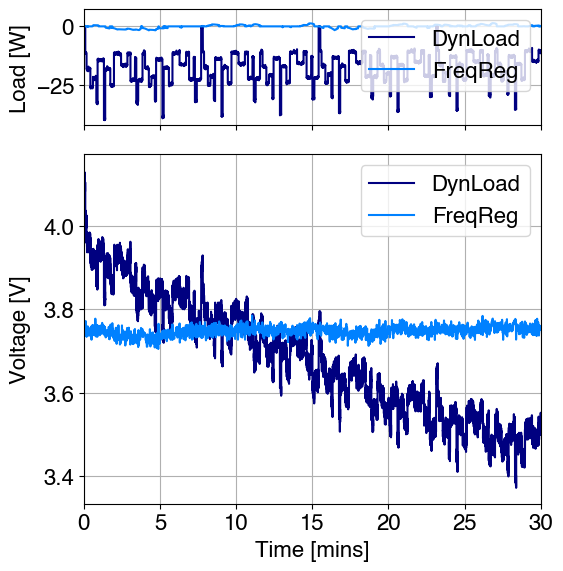

In [9]:
SCALE_FACTOR = 0.015 # Scale the power so that the max power is <1E

df = pd.read_csv("../data/load_profile_freq_reg.csv")
df = df[df.time_s < 3600 * 24]

# Renormalize the load to the nominal energy of the cell being simulated
df.load_w *= - nominal_energy / df.nominal_energy_wh * SCALE_FACTOR

# Create copies with adjusted time
power_data = np.column_stack([df.time_s - df.time_s[0], df.load_w])

# Stack the three arrays vertically
experiment = pybamm.Experiment(
    [pybamm.step.power(power_data)])

sim = pybamm.Simulation(model=model,
                        parameter_values=parameter_values,
                        experiment=experiment,
                        solver=solver)

sol = sim.solve(initial_soc=0.5)

df4 = summarize_solution(sol, voltage_std=VOLTAGE_STD_HIGH)
df4.to_csv('../output/synthetic_data/use_case_4.csv')

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])
plt.subplots_adjust(hspace=0)

ax1.plot(df3['Time [s]']/60, -df3['Power [W]'], c=colors[0], label='DynLoad')
ax1.plot(df4['Time [s]']/60, -df4['Power [W]'], c=colors[1], label='FreqReg')
ax2.plot(df3['Time [s]']/60, df3['Voltage [V]'], c=colors[0], label='DynLoad')
ax2.plot(df4['Time [s]']/60, df4['Voltage [V]'], c=colors[1], label='FreqReg')

ax1.set_ylabel("Load [W]")
ax2.set_ylabel("Voltage [V]")
ax2.set_xlabel("Time [mins]")
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.tight_layout()

fig.align_ylabels([ax1, ax2])

ax1.set_xlim((0, 30))

plt.savefig('../output/figs/use_case_4.png', dpi=150)

# Parameter Extraction Test 1: OCV

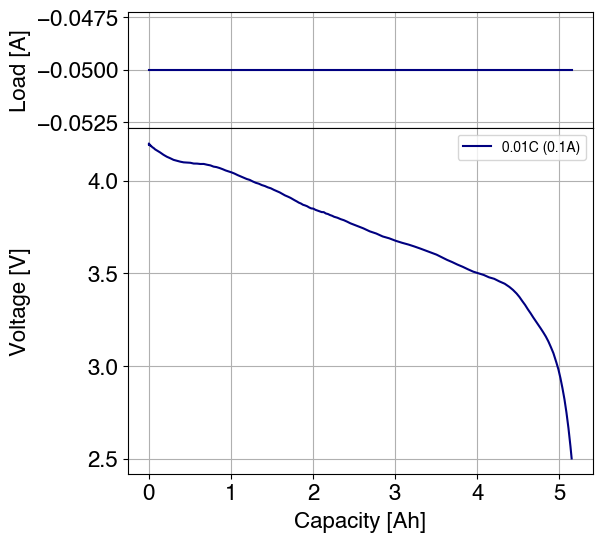

In [10]:
# Set the discharge powers to simulate
c_rate_list = np.array([1/100])

solver           = pybamm.IDAKLUSolver()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])
plt.subplots_adjust(hspace=0)

# Create a colormap with enough colors for our e_rates
colors = plt.cm.jet(np.linspace(0, 1, len(c_rate_list)))

for c_rate, color in zip(c_rate_list, colors):

    experiment = pybamm.Experiment(
        [f"Discharge at {c_rate:.2f}C until 2.5V"]
        )

    sim = pybamm.Simulation(model=model,
                            parameter_values=parameter_values,
                            experiment=experiment,
                            solver=solver)

    sol = sim.solve(initial_soc=1)

    df = summarize_solution(sol, voltage_std=VOLTAGE_STD_LOW)
    df.to_csv(f'../output/synthetic_data/characterization_test_ocv_{c_rate:.2f}C.csv')

    ax1.plot(df['Capacity [Ah]'], -df['Current [A]'], color=color)
    ax2.plot(df['Capacity [Ah]'], df['Voltage [V]'], color=color,
             label=f"{c_rate:.2f}C ({df['Current [A]'].iloc[0]:.1f}A)")
ax1.set_ylabel("Load [A]")
ax2.set_ylabel("Voltage [V]")
ax2.set_xlabel("Capacity [Ah]")

fig.align_ylabels([ax1, ax2])
ax2.legend(fontsize=10)

plt.savefig(f'../output/figs/characterization_test_ocv_{c_rate:.2f}C.png', dpi=150)

# Parameter Extraction Test 2: HPPC

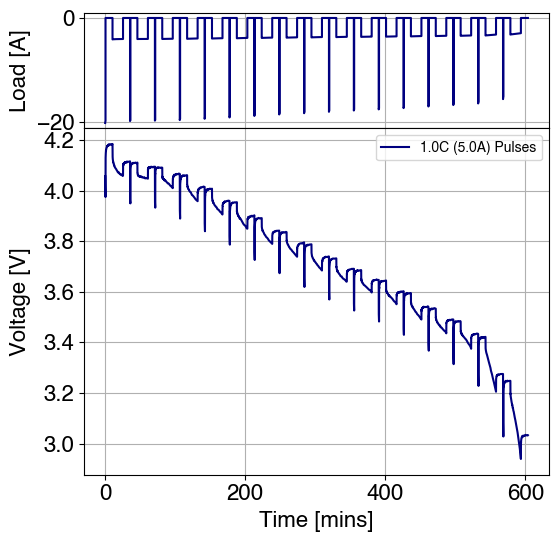

In [11]:
c_rate_list = np.array([1])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])
plt.subplots_adjust(hspace=0)

# Create a colormap with enough colors for our e_rates
colors = plt.cm.jet(np.linspace(0, 1, len(c_rate_list)))

for c_rate, color in zip(c_rate_list, colors):

    experiment = pybamm.Experiment(
        17*[
         f"Discharge at {c_rate}C for 30 seconds or until 2.5V",
         f"Rest for 10 minutes",
         f"Discharge at C/5 for 15 minutes or until 2.5V",
         f"Rest for 10 minutes"
         ]
        )

    sim = pybamm.Simulation(model=model,
                            parameter_values=parameter_values,
                            experiment=experiment,
                            solver=solver)

    sol = sim.solve(initial_soc=1)

    df = summarize_solution(sol, voltage_std=VOLTAGE_STD_LOW)
    df.to_csv(f'../output/synthetic_data/characterization_test_hppc_{c_rate:.1f}C.csv')

    ax1.plot(df['Time [s]']/60, -df['Power [W]'], color=color)
    ax2.plot(df['Time [s]']/60, df['Voltage [V]'], color=color,
             label=f"{c_rate:.1f}C ({df['Current [A]'].iloc[0]:.1f}A) Pulses")

ax1.set_ylabel("Load [A]")
ax2.set_ylabel("Voltage [V]")
ax2.set_xlabel("Time [mins]")

fig.align_ylabels([ax1, ax2])
ax2.legend(fontsize=10)

plt.savefig(f'../output/figs/characterization_test_hppc_{c_rate:.1f}C.png', dpi=150)

# Use profiles for forward predictions

Generate "truth" dataset for attempting to use the digital twin to predict forward in time

## Power availability

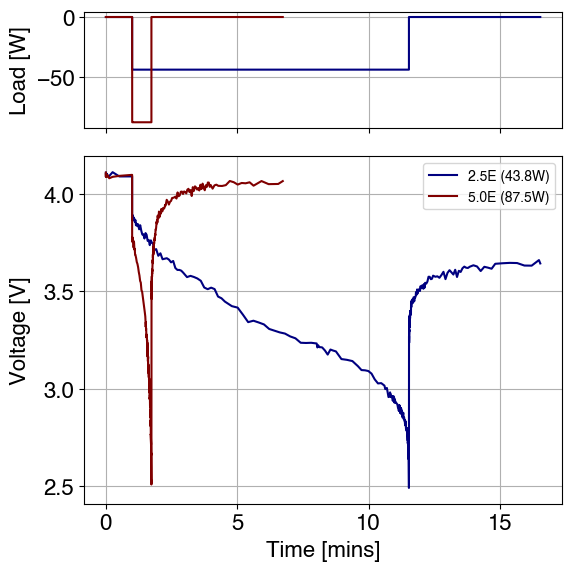

In [12]:
# Set the discharge powers to simulate
e_rate_list = np.array([2.5, 5.0])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])
plt.subplots_adjust(hspace=0)

# Create a colormap with enough colors for our e_rates
colors = plt.cm.jet(np.linspace(0, 1, len(e_rate_list)))

for e_rate, color in zip(e_rate_list, colors):

    experiment = pybamm.Experiment(
        [
            "Rest for 1 minute",
            f"Discharge at {e_rate*nominal_energy:.2f} W until 2.5V",
            "Rest for 5 minutes"
        ]
    )

    sim = pybamm.Simulation(model=model,
                            parameter_values=parameter_values,
                            experiment=experiment,
                            solver=solver)

    sol = sim.solve(initial_soc=0.9)

    df = summarize_solution(sol, voltage_std=VOLTAGE_STD_HIGH)

    df.to_csv(f'../output/synthetic_data/forward_prediction_power_availability{e_rate:.1f}E.csv')

    ax1.plot(df['Time [s]']/60, -df['Power [W]'], color=color)
    ax2.plot(df['Time [s]']/60, df['Voltage [V]'], color=color,
             label=f"{e_rate:.1f}E ({e_rate*nominal_energy:.1f}W)")

ax1.set_ylabel("Load [W]")
ax2.set_ylabel("Voltage [V]")
ax2.set_xlabel("Time [mins]")
fig.align_ylabels([ax1, ax2])
ax2.legend(fontsize=10)
plt.tight_layout()

plt.savefig('../output/figs/forward_prediction_power_availability.png', dpi=150)

## Energy remaining

2025-03-20 10:30:15.142 - [WARNING] callbacks.on_experiment_infeasible_time(240): 

	Experiment is infeasible: default duration (3240.9 seconds) was reached during 'Step([[0.0000e+00 1.9400e-01]
 [1.0000e-01 1.9400e-01]
 [2.0000e-01 1.9400e-01]
 ...
 [3.2407e+03 1.4000e-02]
 [3.2408e+03 1.4000e-02]
 [3.2409e+03 1.4000e-02]], duration=3240.9, period=0.09999999999990905, direction=Discharge)'. The returned solution only contains up to step 1 of cycle 1. Please specify a duration in the step instructions.


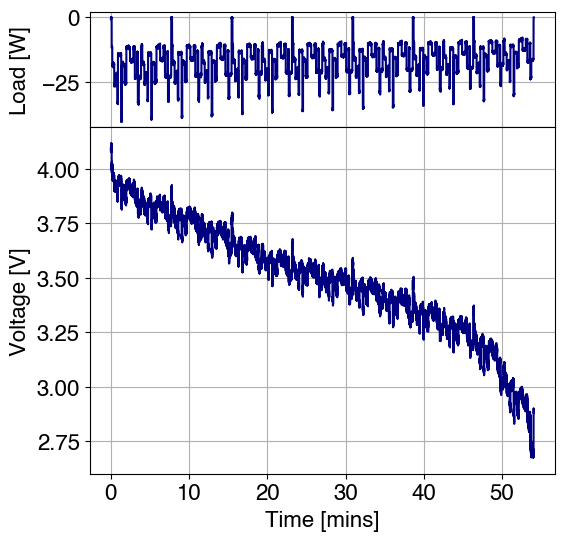

In [13]:
df = pd.read_csv("../data/load_profile_usc_dynamic.csv")

# Create copies with adjusted time
current_data1 = np.column_stack([df.time - df.time[0] + 0*df.time.iloc[-1], df.load])
current_data2 = np.column_stack([df.time - df.time[0] + 1*df.time.iloc[-1], df.load])
current_data3 = np.column_stack([df.time - df.time[0] + 2*df.time.iloc[-1], df.load])
current_data4 = np.column_stack([df.time - df.time[0] + 3*df.time.iloc[-1], df.load])
current_data5 = np.column_stack([df.time - df.time[0] + 4*df.time.iloc[-1], df.load])
current_data6 = np.column_stack([df.time - df.time[0] + 5*df.time.iloc[-1], df.load])
current_data7 = np.column_stack([df.time - df.time[0] + 6*df.time.iloc[-1], df.load])

# Stack the arrays vertically
current_data = np.vstack([current_data1,
                          current_data2,
                          current_data3,
                          current_data4,
                          current_data5,
                          current_data6,
                          current_data7])

experiment = pybamm.Experiment(
    [pybamm.step.current(current_data)])

sim = pybamm.Simulation(model=model,
                        parameter_values=parameter_values,
                        experiment=experiment,
                        solver=solver)

sol = sim.solve(initial_soc=0.9)

df3 = summarize_solution(sol,voltage_std=VOLTAGE_STD_HIGH)

df3.to_csv('../output/synthetic_data/forward_prediction_energy_remaining.csv')

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])
plt.subplots_adjust(hspace=0)

ax1.plot(df3['Time [s]']/60, -df3['Power [W]'], c=colors[0])
ax2.plot(df3['Time [s]']/60, df3['Voltage [V]'], c=colors[0])

ax1.set_ylabel("Load [W]")
ax2.set_ylabel("Voltage [V]")
ax2.set_xlabel("Time [mins]")

fig.align_ylabels([ax1, ax2])

plt.savefig('../output/figs/forward_prediction_energy_remaining.png', dpi=150)